### Experiment: Normalization

**Question**: Is normalization necessary? If so, what kind performs best?

**Hypothesis**: The data is already re-referenced using `mne.set_eeg_reference("average")` during pre-processing. The range used is approximately $[-55, 55]$, models might work better at a more commonly used range of $[0,1]$, or $[-1, 1]$ to keep negative numbers.

**Result**:

#### Part 1: Investigation

In [1]:
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
from pathlib import Path

In [2]:
data_path = Path("data/sat1/split_stage_data.nc")
data = xr.load_dataset(data_path)

##### Histogram of distribution of all values

<xarray.DataArray 'histogram_data' (data_bin: 59)>
array([      3,       2,       2,       4,       8,       7,      12,
            26,      27,      39,      55,      98,     114,     172,
           263,     443,     762,    1349,    2375,    4173,    7773,
         14373,   26982,   49882,   92770,  170517,  310136,  540673,
        888553, 1317833, 1660741, 1691973, 1387367,  953905,  584410,
        337334,  189053,  105587,   59302,   33381,   19463,   11398,
          6749,    3942,    2344,    1453,     898,     504,     286,
           204,     119,      77,      30,      34,      18,      14,
             6,       0,       2])
Coordinates:
  * data_bin  (data_bin) float64 -60.61 -58.63 -56.65 ... 50.32 52.3 54.28

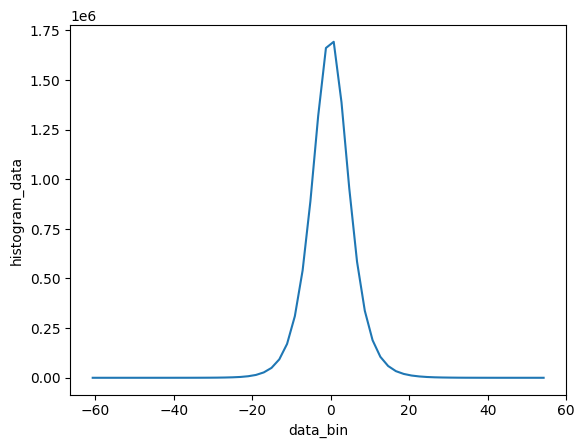

In [3]:
max = data.max().data.item()
min = data.min().data.item()
bins = np.linspace(min, max, 60)
hist = histogram(data.data, bins=bins, block_size=data.samples.size)
display(hist)
hist.plot()

##### Histogram of distribution for each channel

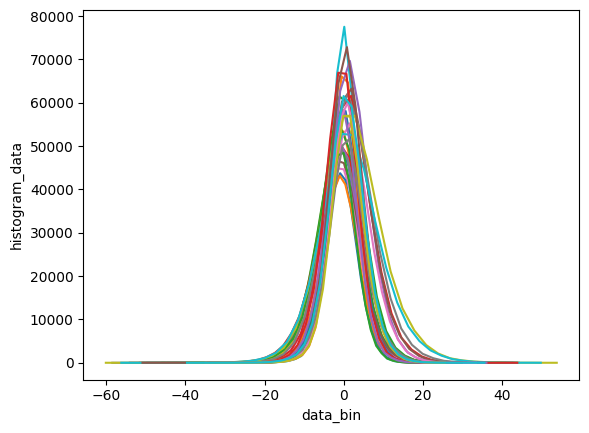

In [4]:
for channel in data.channels:
    data_subset = data.sel(channels=channel)
    max = data_subset.max().data.item()
    min = data_subset.min().data.item()
    bins = np.linspace(min, max, 40)
    hist = histogram(data_subset.data, bins=bins, block_size=data_subset.samples.size)
    hist.plot()

#### Part 2: Experiment

In [1]:
from shared.training import k_fold_cross_validate, get_compile_kwargs
from shared.normalization import *
from shared.models import SAT1Base
from shared.utilities import print_results
import tensorflow as tf
import gc
from pathlib import Path
import xarray as xr
%env TF_FORCE_GPU_ALLOW_GROWTH=true
%env TF_GPU_ALLOCATOR=cuda_malloc_async

2023-10-22 11:02:54.238982: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-22 11:02:55.251711: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


env: TF_FORCE_GPU_ALLOW_GROWTH=true
env: TF_GPU_ALLOCATOR=cuda_malloc_async


In [2]:
data_path = Path("data/sat1/split_stage_data.nc")

data = xr.load_dataset(data_path)

In [3]:
norm_fns = [norm_dummy, norm_0_to_1, norm_min1_to_1]


def test_normalization(norm_fn):
    tf.keras.backend.clear_session()
    print(f"Testing norm_fn: {norm_fn.__name__}")
    model = SAT1Base(len(data.channels), len(data.samples), len(data.labels))
    model.compile(**get_compile_kwargs())
    train_kwargs = {
        "logs_path": Path("logs/exp_normalization/"),
        "additional_info": {"norm_fn": norm_fn.__name__},
        "additional_name": f"norm_fn-{norm_fn.__name__}",
    }
    result = k_fold_cross_validate(
        data, model, k=5, normalization_fn=norm_fn, train_kwargs=train_kwargs
    )
    print_results(result)
    del model
    gc.collect()

In [4]:
test_normalization(norm_fns[0])

Testing norm_fn: norm_dummy


2023-10-22 10:36:47.836122: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 10:36:47.925937: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 10:36:47.926013: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 10:36:47.928986: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 10:36:47.929053: I tensorflow/compile

Fold 1: test fold: ['0009' '0017' '0001' '0024' '0012']
Epoch 1/20


2023-10-22 10:36:51.733826: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-22 10:36:52.786923: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-22 10:36:53.295220: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc7ea74ac60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-22 10:36:53.295255: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-10-22 10:36:53.322122: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-22 10:36:53.503013: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

997/997 [==============================] - 18s 13ms/step - loss: 3.7195 - accuracy: 0.7264 - val_loss: 0.5801 - val_accuracy: 0.7894
Epoch 2/20
997/997 [==============================] - 14s 13ms/step - loss: 2.7143 - accuracy: 0.7990 - val_loss: 0.5088 - val_accuracy: 0.8142
Epoch 3/20
997/997 [==============================] - 14s 13ms/step - loss: 2.3987 - accuracy: 0.8224 - val_loss: 0.5075 - val_accuracy: 0.8078
Epoch 4/20
997/997 [==============================] - 14s 13ms/step - loss: 2.1764 - accuracy: 0.8396 - val_loss: 0.5053 - val_accuracy: 0.8172
Epoch 5/20
997/997 [==============================] - 14s 13ms/step - loss: 1.9467 - accuracy: 0.8544 - val_loss: 0.4858 - val_accuracy: 0.8177
Epoch 6/20
997/997 [==============================] - 14s 13ms/step - loss: 1.8101 - accuracy: 0.8680 - val_loss: 0.4844 - val_accuracy: 0.8248
Epoch 7/20
997/997 [==============================] - 14s 14ms/step - loss: 1.6476 - accuracy: 0.8749 - val_loss: 0.5042 - val_accuracy: 0.8312
Epo

In [4]:
test_normalization(norm_fns[1])

Testing norm_fn: norm_0_to_1


2023-10-22 10:46:54.000374: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 10:46:54.023566: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 10:46:54.023662: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 10:46:54.025706: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 10:46:54.025780: I tensorflow/compile

Fold 1: test fold: ['0009' '0017' '0001' '0024' '0012']
Epoch 1/20


2023-10-22 10:46:57.447727: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-22 10:46:58.095238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-22 10:46:58.402979: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fcb0ab44ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-22 10:46:58.403016: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-10-22 10:46:58.409074: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-22 10:46:58.516146: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

997/997 [==============================] - 17s 13ms/step - loss: 5.6779 - accuracy: 0.5244 - val_loss: 1.0716 - val_accuracy: 0.5524
Epoch 2/20
997/997 [==============================] - 14s 13ms/step - loss: 4.2386 - accuracy: 0.6634 - val_loss: 0.6456 - val_accuracy: 0.7598
Epoch 3/20
997/997 [==============================] - 14s 13ms/step - loss: 3.0597 - accuracy: 0.7679 - val_loss: 0.5699 - val_accuracy: 0.7835
Epoch 4/20
997/997 [==============================] - 14s 13ms/step - loss: 2.7356 - accuracy: 0.7952 - val_loss: 0.5365 - val_accuracy: 0.7992
Epoch 5/20
997/997 [==============================] - 14s 13ms/step - loss: 2.5767 - accuracy: 0.8092 - val_loss: 0.5120 - val_accuracy: 0.8024
Epoch 6/20
997/997 [==============================] - 14s 13ms/step - loss: 2.4135 - accuracy: 0.8176 - val_loss: 0.5028 - val_accuracy: 0.8120
Epoch 7/20
997/997 [==============================] - 14s 13ms/step - loss: 2.2623 - accuracy: 0.8273 - val_loss: 0.5093 - val_accuracy: 0.8115
Epo

In [4]:
test_normalization(norm_fns[2])

Testing norm_fn: norm_min1_to_1


2023-10-22 11:03:02.475514: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 11:03:02.508447: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 11:03:02.508578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 11:03:02.510982: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 11:03:02.511056: I tensorflow/compile

Fold 1: test fold: ['0009' '0017' '0001' '0024' '0012']
Epoch 1/20


2023-10-22 11:03:06.234710: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-22 11:03:06.890039: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-22 11:03:07.202117: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0bbf1ec1e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-22 11:03:07.202149: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-10-22 11:03:07.208187: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-22 11:03:07.315334: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

997/997 [==============================] - 17s 14ms/step - loss: 3.8123 - accuracy: 0.7146 - val_loss: 0.5933 - val_accuracy: 0.7805
Epoch 2/20
997/997 [==============================] - 14s 14ms/step - loss: 2.9287 - accuracy: 0.7887 - val_loss: 0.5351 - val_accuracy: 0.8066
Epoch 3/20
997/997 [==============================] - 14s 13ms/step - loss: 2.6063 - accuracy: 0.8096 - val_loss: 0.4971 - val_accuracy: 0.8196
Epoch 4/20
997/997 [==============================] - 14s 14ms/step - loss: 2.3776 - accuracy: 0.8274 - val_loss: 0.4852 - val_accuracy: 0.8226
Epoch 5/20
997/997 [==============================] - 14s 14ms/step - loss: 2.2178 - accuracy: 0.8376 - val_loss: 0.4982 - val_accuracy: 0.8223
Epoch 6/20
997/997 [==============================] - 14s 14ms/step - loss: 2.0459 - accuracy: 0.8484 - val_loss: 0.4885 - val_accuracy: 0.8233
Epoch 7/20
997/997 [==============================] - 14s 14ms/step - loss: 1.9223 - accuracy: 0.8573 - val_loss: 0.4831 - val_accuracy: 0.8253
Epo

In [5]:
# View results in Tensorboard
! tensorboard --logdir logs/exp_normalization/

2023-10-17 16:53:32.560154: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.13.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C
